### Trabalho Final - Aprendizado de Máquina
- Vinícius Braga Freire - 2020054889

#### 1. Processamento de dados

##### 1.1. Interações

Vamos tratar os dados das interações entre indivíduos. Este dado nos dá a informação em que dia, por quanto tempo e a qual reunião um funcionário participou.

Deste dado, iremos gerar um grafo (matriz de adjacência) que irá indicar quantas vezes uma certa pessoa se encontrou com outra. O valor de quantas vezes uma pessoa se encontrou com outra tem forte correlação com estas pertencerem a um mesmo grupo.

Note que reuniões com mais de 1 segundo serão consideradas, além de que reuniões que tenham tido mais de 10 participantes serão descartadas (pois essas reuniões grandes tendem a ser feitas para a empresa toda/setor inteiro).

In [5]:
import pandas as pd
import numpy as np

interacoes_df = pd.read_csv("./data/in/interacoes.csv", encoding="cp860", sep=";")
print(interacoes_df.info())
interacoes_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149006 entries, 0 to 149005
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   Data             149006 non-null  object
 1   Matricula        149006 non-null  int64 
 2   Departamento     149006 non-null  object
 3   Nome da Reuniao  149006 non-null  object
 4   Nome da Janela   149006 non-null  object
 5   Tempo na Janela  149006 non-null  object
dtypes: int64(1), object(5)
memory usage: 6.8+ MB
None


,Data,Matricula,Departamento,Nome da Reuniao,Nome da Janela,Tempo na Janela
0,31/12/2022,10085103,CTN-01,-,dtOthers,00:00:56
1,31/12/2022,10085103,CTN-01,Daniela Cristina Arena Vaz,Daniela Cristina Arena Vaz | Microsoft Teams,00:01:02
2,31/12/2022,10085103,CTN-01,[War Room] - Carga Suprimentos,[War Room] - Carga Suprimentos | Microsoft Teams,00:04:58
3,31/12/2022,10085103,CTN-01,Cutover/Golive Florestal,Cutover/Golive Florestal | Microsoft Teams,00:04:46
4,31/12/2022,10085103,CTN-01,N∩┐╜cleo Duro do Go Live,N∩┐╜cleo Duro do Go Live | Microsoft Teams,00:07:52


Agora vamos filtrar a base de dados para posteriormente obter todas as equipes. Para tal, temos que garantir que os dados:
    
- Não tenha uma mesma pessoa considerada mais de 1 vez em uma reunião.
- Que reuniões com mais de 10 pessoas sejam descartadas.
- Reuniões com menos de 1 pessoa sejam descartadas.

In [12]:
# Pega todas reuniões e agrupa em função da reunião e da sua data
interacoes_grouped = (
    interacoes_df[["Data", "Nome da Reuniao", "Matricula"]]
    .groupby(["Data", "Nome da Reuniao"])
)

# Pega quantas pessoas foram pra cada reunião e filtra as com menos ou com exatamente 10 pessoas e aquelas reunões que só apareceram 1
interacoes_df["n_pessoas_na_reuniao"] = interacoes_grouped.transform("count")["Matricula"].values
# Garante que não teremos uma mesma pessoa repetida em uma mesma reunião, evitando ciclos inuteis no grafo
interacoes_lt_10 =  interacoes_df[["Data", "Nome da Reuniao", "Matricula", "n_pessoas_na_reuniao"]].drop_duplicates()
interacoes_lt_10 = interacoes_lt_10.query("n_pessoas_na_reuniao <= 10 and n_pessoas_na_reuniao > 1")
interacoes_lt_10

,Data,Nome da Reuniao,Matricula,n_pessoas_na_reuniao
2,31/12/2022,[War Room] - Carga Suprimentos,10085103,4
3,31/12/2022,Cutover/Golive Florestal,10085103,3
4,31/12/2022,N∩┐╜cleo Duro do Go Live,10085103,3
5,31/12/2022,War Room - Subida J1BTAX e BRF PLUS,10085103,2
9,31/12/2022,Cutover/Golive Florestal,10002481,3
...,...,...,...,...
148992,04/07/2022,Priscila Santanna Barros,10089556,2
148994,04/07/2022,Henry Wood da Silva,10089556,4
148996,04/07/2022,Alinhamento Atividades | Dexco,10089556,2
149000,01/07/2022,-,10079664,2


Agora precisamos converter esses dados em um grafo não direcionado e ponderado, onde cada aresta significa que dois funcionários tiveram em uma mesma reunião e o peso dessa aresta indica quantas vezes essas pessoas se encontraram.

Aqui devemos garantir que pessoas que se encontraram menos de 5 vezes tenham tal relação descartada (5 encontros ou menos encontros é forte indício de não pertencimento a um mesmo grupo).

In [15]:
import networkx as nx
import matplotlib.pyplot as plt

def generate_graph(df):
    grouped_df = df.groupby(['Data', 'Nome da Reuniao'])
    G = nx.Graph()
    
    # Para cada reunião registrada
    for (date,name), people in grouped_df:
        n_people = people.shape[0]
        
        # Cria uma aresta (ou aumenta o peso de aresta existente) entre cada uma das pessoas que participaram dessa reunião
        for i in range(n_people):
            _from = int(people.iloc[i]['Matricula'])
            for j in range(i + 1, n_people):
                to = int(people.iloc[j]['Matricula'])
                
                # If the edge has already been created
                if G.has_edge(_from, to):
                    G[_from][to]['weight'] += 1
                # Initialize an edge
                else:
                    G.add_edge(_from, to, weight= 1)

    # Remove todas pessoas cujo numero de encontros foi menor que 5
    to_remove = [(u,v) for u, v, w in G.edges(data=True) if w['weight'] < 5]
    G.remove_edges_from(to_remove)

    #
    return G

interacoes_g = generate_graph(interacoes_lt_10)

A seguir vamos vizualizar como está o grafo. Aqui vemos que após filtrar as interações entre pessoas que se encontraram menos que 5 vezes restaram alguns nós soltos (pessoas que baseados nessa métrica não se encontram com ninguem desse conjunto de dados).

Assim, o objeto de nosso estudo será esse cluster central, logo vamos filtrar novamente os dados.

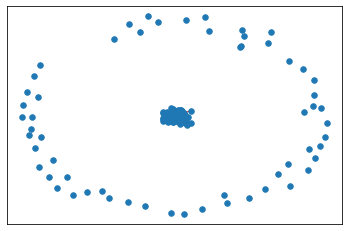

In [16]:
# Apenas um esquematico do grafo completo
nx.draw_networkx(interacoes_g, with_labels=False, node_size=30, edge_color='r')
plt.show()

Assim, vamos remover todos nós que tenham grau 0. O resultado é o grafo a seguir.

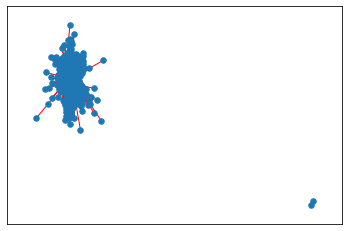

In [17]:
# Acha todos nós de grau 0
to_be_removed = [x for x in interacoes_g.nodes() if interacoes_g.degree(x) == 0]
# Remove estes nós
interacoes_g.remove_nodes_from(to_be_removed)

nx.draw_networkx(interacoes_g, with_labels=False, node_size=30, edge_color='r')
plt.show()

Procura por todas cliques máximas (busca todas equipes). Vamos garantir que as equipes tenham mais de 2 pessoas.

Assim, geramos uma lista `teams` onde cada posição contém uma lista de matrículas. Cada uma dessas está representando uma possível equipe (com pelo menos 3 pessoas) que poderia ser gerada dada a métrica de número de encontros que utilizamos.

In [18]:
# Acha todas cliques maximas
teams = list(nx.clique.find_cliques(interacoes_g))
# Filtra os times para manter somente times com 3 ou mais pessoas
teams = sorted(list(filter(lambda t: t.__len__() > 2, teams)))
teams

[[10002481, 10023181, 10120161, 10037193, 10080186, 10028494],
 [10002481, 10023181, 10120271, 10074588, 10003664, 10028494, 10037193],
 [10002481, 10023181, 10120271, 10074588, 10003664, 10028494, 10084469],
 [10002481,
  10023181,
  10120271,
  10074588,
  10089011,
  10028494,
  10037193,
  10081571],
 [10002481,
  10023181,
  10120271,
  10074588,
  10089011,
  10028494,
  10073793,
  10084469,
  10088886,
  10038042],
 [10002481,
  10023181,
  10120271,
  10074588,
  10089011,
  10028494,
  10073793,
  10084469,
  10088886,
  10081571,
  10025436],
 [10002481,
  10023181,
  10120271,
  10074588,
  10089011,
  10028494,
  10080186,
  10037193,
  10038042],
 [10002481,
  10023181,
  10120271,
  10074588,
  10089011,
  10080237,
  10038042,
  10080215,
  10073793,
  10084469,
  10088886],
 [10002481,
  10023181,
  10120271,
  10074588,
  10089011,
  10080237,
  10038042,
  10080215,
  10080186,
  10037193],
 [10002481,
  10023181,
  10120271,
  10074588,
  10089011,
  10080237,
  101

Agora vamos fazer uma análise exploratória simples em cima desta lista de equipes:

In [36]:
# Função que gera um novo grafo em cima apenas das pessoas restantes após toda a filtragem anterior,
# além de retornar algumas métricas e estatisticas coletadas sobre estes times 
def generate_graph_from_teams(teams: list[list[int]]):
    G = nx.Graph()
    people_per_team = []
    
    # Para cada reunião registrada
    for team in teams:
        people_per_team.append(team.__len__())
        
        # Cria uma aresta (ou aumenta o peso de aresta existente) entre cada uma das pessoas que participaram dessa reunião
        for i in range(len(team)):
            _from = team[i]
            for j in range(i + 1, people_per_team[-1]):
                to = team[j]
                
                # If the edge has already been created
                if G.has_edge(_from, to):
                    G[_from][to]['weight'] += 1
                # Initialize an edge
                else:
                    G.add_edge(_from, to, weight= 1)

    #
    return G

teams_g = generate_graph_from_teams(teams)

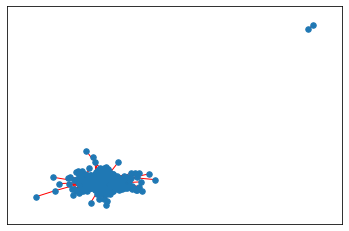

In [37]:

nx.draw_networkx(interacoes_g, with_labels=False, node_size=30, edge_color='r')
plt.show()

Note na celula o número de possíveis times que podem ser formados (número de cliques completas) e o número de pessoas distintas que restaram neste nosso grafo.

In [26]:

print("Número de possíveis times baseado na metrica de encontro:\n" + str(teams.__len__()) + "\n\nNúmero de pessoas restantes: ")

Número de possíveis times baseado na metrica de encontro:
1374

Número de pessoas restantes: 


##### 1.2. Infos Pessoais

QAAAA

In [ ]:
import pandas as pd

infos_pessoas_df = pd.read_csv("./data/in/infos_pessoas.csv", encoding="cp860")
infos_pessoas_df.head()

#### 2. Treinamento de modelo

#### 3. Resultado e validação de modelo